**2.1.1: Setup**

Importing various required modules and the MNIST dataset. Initializing randomizer.

In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
import torch
from torch import Tensor, nn
from torchvision.datasets import MNIST
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.transforms import ToTensor
import statistics
import math
# Static random seed
np.random.seed(89)

# Need to convert data to Tensor, because the DataLoader iterator refuses to work with PIL image objects.
# Also experienced other trouble when having the PIL image
pil2tensor = lambda x: ToTensor()(x).squeeze()   # ToTensor return (64,1,28,28), the squeeze() call removes the 1 dimension

# Standard MNIST dataset (not binarized)
mnist_train_data = MNIST("./temp/", transform=pil2tensor, download=True, train=True)
mnist_test_data = MNIST("./temp/", transform=pil2tensor, download=True, train=False)

**2.1.2: Plot 8x8 random samples**

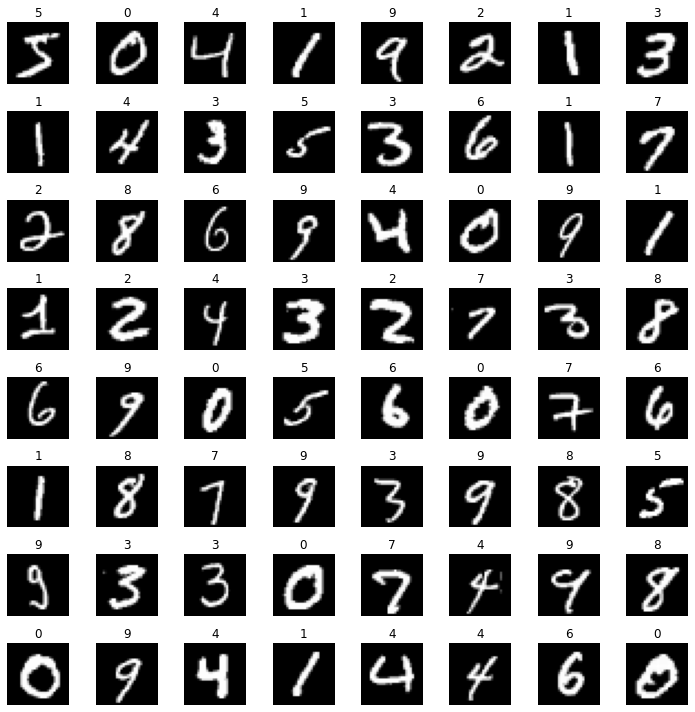

In [2]:
from torch.utils.data import DataLoader

mnist_train_loader = DataLoader(mnist_train_data, batch_size = 64)
images, labels = next(iter(mnist_train_loader))
fig, axs = plt.subplots(8, 8, figsize=(10, 10), squeeze=False)
i = 0
for ax in axs.flat:
    ax.imshow(images[i], cmap='gray')
    ax.set_title("%s" % (labels[i].item()))
    ax.axis('off')
    i += 1
plt.tight_layout()

**2.1.3: Implement dynamic binarization**

Sampling binarized pixels using intensity as probability.

In [3]:
# Setup Bernoulli statistical sampling conversion from grey-scale to binary
from torchvision import transforms

# When indexing into 'binarized_mnist_xxx_data' we implicitly call '__getitem__', which
# normalizes MNIST data. Thus 'transform' gets values in the range [0,1].
binarized_mnist_train_data = MNIST("./temp/",
                                   download=True,
                                   train=True,
                                   transform=transforms.Compose([pil2tensor,
                                                                 transforms.Lambda(lambda x: torch.bernoulli(x))]))
binarized_mnist_test_data = MNIST("./temp/",
                                  download=True,
                                  train=False,
                                  transform=transforms.Compose([pil2tensor,
                                                                transforms.Lambda(lambda x: torch.bernoulli(x))]))

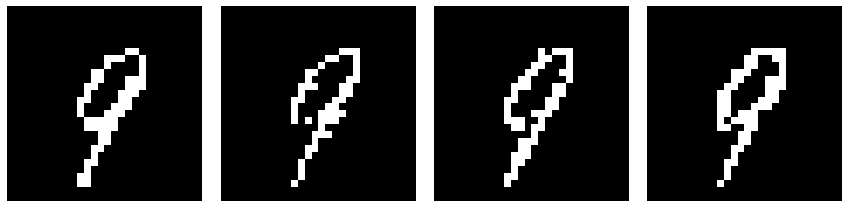

In [4]:
# Plot same image a couple of times to verify we are doing statistical sampling every time the image is drawn
fig, axs = plt.subplots(1, 4, figsize=(12, 3), squeeze=False)
for ax in axs.flat:
    sample = binarized_mnist_train_data.__getitem__(22)[0]
    assert torch.max(sample) == 1.0
    assert torch.min(sample) == 0.0
    ax.imshow(sample, cmap='gray')
    ax.axis('off')
plt.tight_layout()

**2.1.4: Plot binarized MNIST samples**

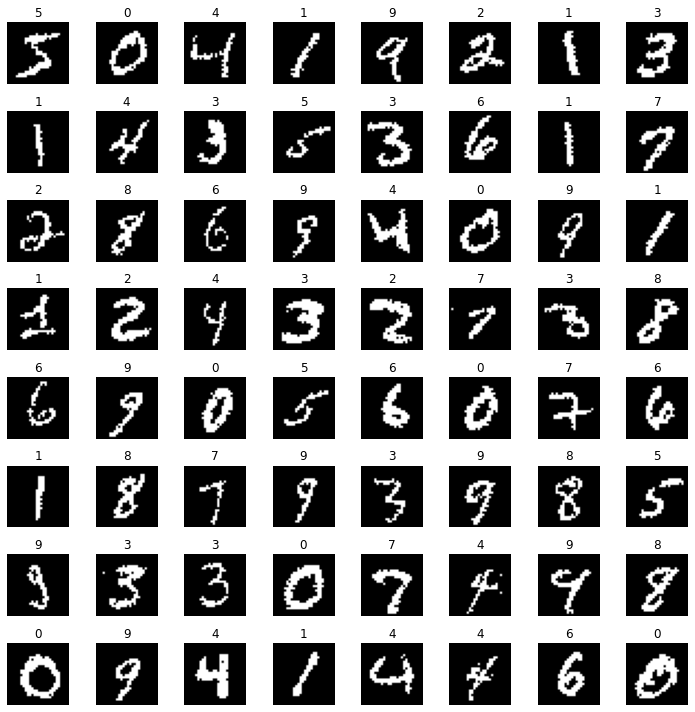

In [5]:
from torch.utils.data import DataLoader

binarized_mnist_train_loader = DataLoader(binarized_mnist_train_data, batch_size = 64)
images, labels = next(iter(binarized_mnist_train_loader))
fig, axs = plt.subplots(8, 8, figsize=(10, 10), squeeze=False)
i = 0
for ax in axs.flat:
    ax.imshow(images[i], cmap='gray')
    ax.set_title("%s" % (labels[i].item()))
    ax.axis('off')
    i += 1
plt.tight_layout()

**2.2.1.1: VAE implementation**

In [6]:
# Implement reparameterized diagonal gaussian
from torch.distributions import Distribution

class ReparameterizedDiagonalGaussian(Distribution):
    def __init__(self, mu: Tensor, log_sigma: Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        
    def sample_epsilon(self) -> Tensor:
        return torch.empty_like(self.mu).normal_()
        
    def sample(self) -> Tensor:
        with torch.no_grad():
            return self.rsample()
        
    def rsample(self) -> Tensor:
        return self.mu + self.sigma*self.sample_epsilon()
        
    def log_prob(self, z:Tensor) -> Tensor:
        from torch.distributions import Normal 
        return  Normal(loc=self.mu, scale=self.sigma).log_prob(z)

In [7]:
# Return sum of values in all dimenensions, except the first one, which is assumed to be batch
def reduce(x: Tensor) -> Tensor:
    return x.view(x.size(0), -1).sum(dim=1)

In [8]:
from typing import Dict, Any

from torch.distributions import Bernoulli

# Define hidden layer topology - list of sizes of hidden layers
encoder_dimensions = [512, 256, 128]
decoder_dimensions = [128, 256, 512]
apply_per_layer_batchnorm = False

# Implement VAE
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_shape:torch.Size, latent_features:int) -> None:
        super(VariationalAutoEncoder, self).__init__()

        # Core parameters
        self.input_shape = input_shape
        self.latent_features = latent_features
        self.observation_features = np.prod(input_shape)
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))
        #self.prior_params = torch.zeros(torch.Size([1, 2*latent_features]))
        
        # Dynamically constructing the encoder network
        encoder_constructor = []
        encoder_constructor.append(nn.Linear(in_features=self.observation_features, out_features=encoder_dimensions[0]))
        encoder_constructor.append(nn.ReLU())
        if apply_per_layer_batchnorm:
            encoder_constructor.append(nn.BatchNorm1d(num_features=encoder_dimensions[0]))
        for i in range(len(encoder_dimensions)-1):
            encoder_constructor.append(nn.Linear(in_features=encoder_dimensions[i], out_features=encoder_dimensions[i+1]))
            encoder_constructor.append(nn.ReLU())
            if apply_per_layer_batchnorm:
                encoder_constructor.append(nn.BatchNorm1d(num_features=encoder_dimensions[i+1]))
        encoder_constructor.append(nn.Linear(in_features=encoder_dimensions[-1], out_features=2*self.latent_features))
        self.encoder = nn.Sequential(*encoder_constructor)

        # Dynamically constructing the decoder network
        decoder_constructor = []
        decoder_constructor.append(nn.Linear(in_features=self.latent_features, out_features=decoder_dimensions[0]))
        decoder_constructor.append(nn.ReLU())
        if apply_per_layer_batchnorm:
            decoder_constructor.append(nn.BatchNorm1d(num_features=decoder_dimensions[0]))
        for i in range(len(decoder_dimensions)-1):
            decoder_constructor.append(nn.Linear(in_features=decoder_dimensions[i], out_features=decoder_dimensions[i+1]))
            decoder_constructor.append(nn.ReLU())
            if apply_per_layer_batchnorm:
                decoder_constructor.append(nn.BatchNorm1d(num_features=decoder_dimensions[i+1]))
        decoder_constructor.append(nn.Linear(in_features=decoder_dimensions[-1], out_features=self.observation_features))
        self.decoder = nn.Sequential(*decoder_constructor)
    
    # Encode input into posterior distribution
    def encode(self, x: Tensor) -> Distribution:
        h_x = self.encoder(x)
        mu, log_sigma =  h_x.chunk(2, dim=-1)
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    # Decode latent variables into reconstruction
    def decode(self, z: Tensor) -> Distribution:
        px_logits = self.decoder(z)
        px_logits = px_logits.view(-1, *self.input_shape)
        return Bernoulli(logits=px_logits)
    
    # Get the prior distribution
    def prior(self, batch_size: int = 1) -> Distribution:
        local_prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = local_prior_params.chunk(2, dim=-1)
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    # Sample from a provided distribution
    def sample(self, distribution: ReparameterizedDiagonalGaussian) -> Tensor:
        return distribution.rsample()
    
    # Compute the ELBO
    def elbo(self, prior: Distribution, posterior: Distribution, reconstruction: Distribution, x: Tensor, z: Tensor) -> float:
        tst = reconstruction.sample()
        x = x.view(x.size(0), -1)
        log_px = reduce(reconstruction.log_prob(x))
        log_pz = reduce(prior.log_prob(z))
        log_qz = reduce(posterior.log_prob(z))
        kl = log_qz - log_pz
        elbo = log_px - kl
        return elbo
    
    def forward(self, x: Tensor) -> Dict[str, Any]:
        # flatten the input
        x = x.view(x.size(0), -1)
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.encode(x)
        # define the prior p(z)
        pz = self.prior(batch_size=x.size(0))
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample()
        # define the observation model p(x|z) = B(x | g(z))
        px = self.decode(z)
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}

In [9]:
# Instantiate a VAE
testVAE = VariationalAutoEncoder(sample.flatten().shape, 5)
print(testVAE.encoder)
print(testVAE.decoder)

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=10, bias=True)
)
Sequential(
  (0): Linear(in_features=5, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=512, bias=True)
  (5): ReLU()
  (6): Linear(in_features=512, out_features=784, bias=True)
)


**2.2.1.2: Print samples from untrained VAE**

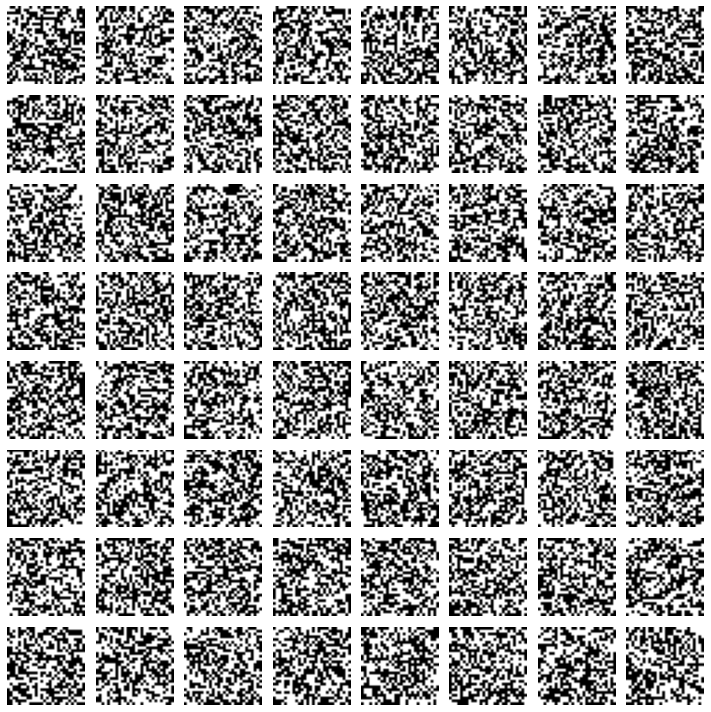

In [10]:
# Method 1: Decoding sample from prior
testVAE.cpu()
testVAE.eval()

prior = testVAE.prior(64)
prior_sample = testVAE.sample(prior)
decoded_prior_sample = testVAE.decode(prior_sample)
sampled_decode_content = decoded_prior_sample.sample().view(64, 28, 28)

fig, axs = plt.subplots(8, 8, figsize=(10, 10), squeeze=False)
i = 0
for ax in axs.flat:
    ax.imshow(sampled_decode_content[i], cmap='gray')
    ax.axis('off') 
    i += 1
plt.tight_layout()

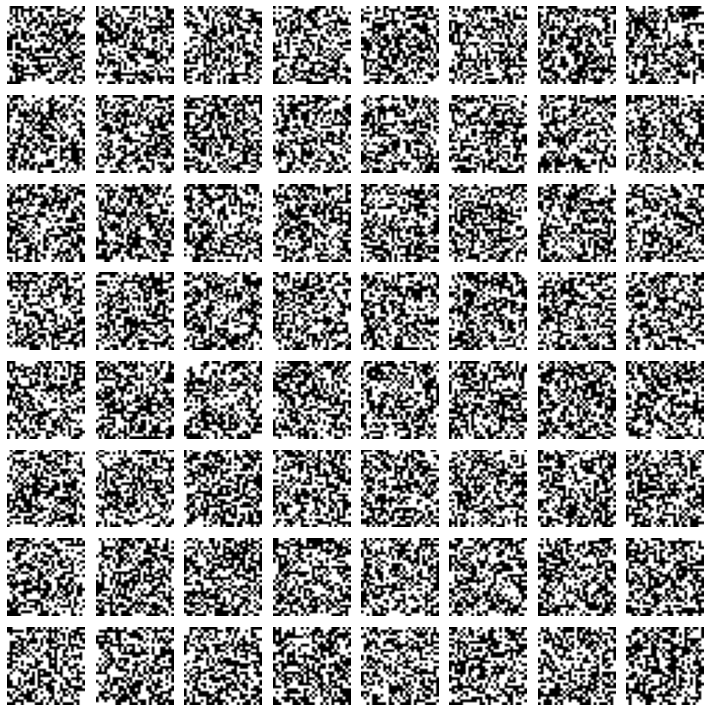

In [11]:
# Method 2: Reconstruction of input from binarized MNIST
a = random.choices(binarized_mnist_train_data,k=64)
b = [x[0] for x in a]
img = torch.stack(b)
sampled_decode_content = testVAE(img)['px'].sample().view(-1,28,28)

fig, axs = plt.subplots(8, 8, figsize=(10, 10), squeeze=False)
i = 0
for ax in axs.flat:
    ax.imshow(sampled_decode_content[i], cmap='gray')
    ax.axis('off') 
    i += 1
plt.tight_layout()

**2.2.1.3: Compute ELBO of 64 samples**

In [12]:
sample_cnt = 64
samples = np.zeros(shape=(sample_cnt, 784))
labels = np.zeros(shape=(sample_cnt, 1))
for i in range(sample_cnt):
    sample = random.choice(binarized_mnist_train_data)
    samples[i] = sample[0].view(1, -1).numpy()
    labels[i] = sample[1]

prior = testVAE.prior(sample_cnt)
samples_tensor = Tensor(samples)
posterior = testVAE.encode(samples_tensor)
z = testVAE.sample(posterior) # Random sampling
reconstruction = testVAE.decode(z)
elbo = testVAE.elbo(prior, posterior, reconstruction, samples_tensor, z) 

# 'float64' required because 'stdev' chokes on 'float32' which is the default type when detaching from GPU
elbo_ary = elbo.detach().numpy().astype('float64')
elbo_stddev = statistics.stdev(elbo_ary)
elbo_mean = statistics.mean(elbo_ary)
print("ELBO on %d train data: %.1f +/-%.1f" % (sample_cnt, elbo_mean,elbo_stddev))

ELBO on 64 train data: -544.6 +/-0.6


**2.2.2.1 and 2.2.2.2: Implementing train and test methods in training helper class**

In [13]:
from torch import optim

class VAE_Trainer:
    def __init__(self, network: VariationalAutoEncoder, train: DataLoader, test: DataLoader):
        self.VAE = network
        self.train_data = train
        self.test_data = test
        if torch.cuda.is_available():
            self.device = "cuda:0"
            network.cuda()
        else:
            self.device = "cpu"
            network.cpu()
        self.optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)
    
    def train(self):
        self.VAE.train()
        for images, labels in self.train_data:
            images = images.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.VAE(images)
            loss = -self.VAE.elbo(outputs['pz'], outputs['qz'], outputs['px'], images, outputs['z']).mean()
            loss.backward()
            self.optimizer.step()
    
    def test(self):
        self.VAE.eval()
        losses = []
        i = 0
        for images, labels in self.test_data:
            images = images.to(self.device)
            outputs = self.VAE(images)
            elbos = self.VAE.elbo(outputs['pz'], outputs['qz'], outputs['px'], images, outputs['z']).cpu().detach().numpy()
            losses = np.append(losses, elbos)
        loss = -np.mean(losses)
        print("Loss: ", loss)

**2.2.2.3: Training the network**

**ToDo:** Implement state saving

In [14]:
binarized_mnist_test_loader = DataLoader(binarized_mnist_test_data, batch_size = 64)

trainer = VAE_Trainer(testVAE, binarized_mnist_train_loader, binarized_mnist_test_loader)
epochs = 200

for i in range(epochs):
    print("Training epoch ", i)
    trainer.train()
    print("Testing epoch ", i)
    trainer.test()

Training epoch  0


KeyboardInterrupt: 

**2.2.2.4: Generating samples from trained model**

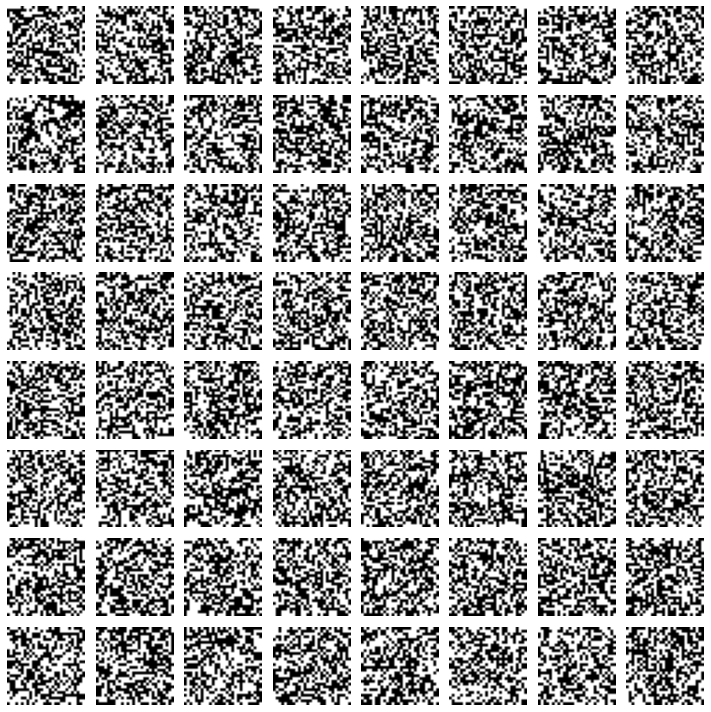

In [15]:
testVAE.cpu()
testVAE.eval()

prior = testVAE.prior(64)
prior_sample = testVAE.sample(prior)
decoded_prior_sample = testVAE.decode(prior_sample)
sampled_decode_content = decoded_prior_sample.sample().view(64, 28, 28)

fig, axs = plt.subplots(8, 8, figsize=(10, 10), squeeze=False)
i = 0
for ax in axs.flat:
    ax.imshow(sampled_decode_content[i], cmap='gray')
    ax.axis('off') 
    i += 1
plt.tight_layout()

In [16]:
sample_cnt = binarized_mnist_test_data.data.shape[0]
#sample_cnt = 100
samples_tensor = torch.empty(sample_cnt,28,28)
for idx in range(samples_tensor.shape[0]):
    samples_tensor[idx] = binarized_mnist_test_data[idx][0]

prior = testVAE.prior(sample_cnt)
samples_tensor = samples_tensor.view(sample_cnt,-1)
samples_tensor.shape
posterior = testVAE.encode(samples_tensor)
z = testVAE.sample(posterior)
reconstruction = testVAE.decode(z)
elbo = testVAE.elbo(prior, posterior, reconstruction, samples_tensor, z) 

# 'float64' required because 'stdev' chokes on 'float32' which is the default type when detaching from GPU
elbo_ary = elbo.detach().numpy().astype('float64')
elbo_stddev = statistics.stdev(elbo_ary)
elbo_mean = statistics.mean(elbo_ary)
print("ELBO on %d test data: %.1f +/-%.1f" % (sample_cnt, elbo_mean,elbo_stddev))

ELBO on 10000 test data: -544.7 +/-0.8


**2.3.1: Extracting 10 samples per class for classification training**

**ToDo:** Consider more elegant solution for classification_sampler

In [17]:
from torch.utils.data.sampler import SubsetRandomSampler
import functools

def classification_sampler(labels):
    indices = []
    for i in range(10):
        #(tmp_indices,) = np.where(functools.reduce(lambda x, y: x | y, [labels.numpy() == i]))
        tmp_indices = np.where(labels.numpy() == i)[0]
        indices.append(random.choices(tmp_indices, k=10))
    indices = torch.Tensor(indices)
    indices = indices.view(1, -1).squeeze().int()
    return SubsetRandomSampler(indices)
    
classification_loader = DataLoader(binarized_mnist_train_data, batch_size=25,
                                   sampler=classification_sampler(binarized_mnist_train_data.train_labels))
# Accuracy of Test Accuracy estimates based on batch_size
#  10k: baseline
# 2000: 0.5% 0.9% 1.6%
# 5000: 0.2% 0.9% 1.2%
# Adding 2.5 sec by using all test data instead of just 1000. Worth the price.
classification_loader_test = DataLoader(binarized_mnist_test_data, shuffle=True, batch_size=10000)

D:\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


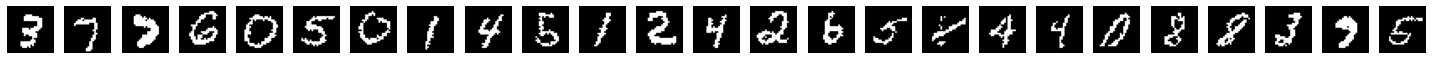

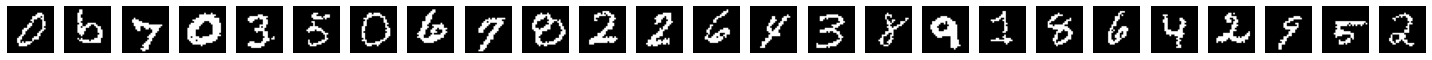

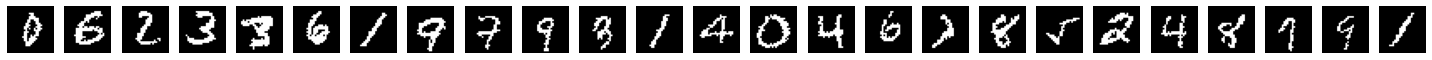

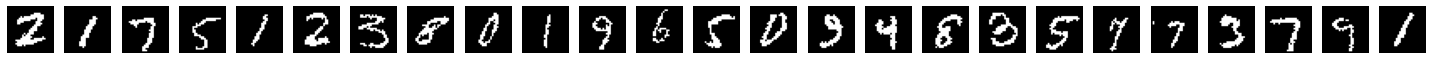

In [18]:
# visual check that the same 100 pictures are printed, and only permutated. Evaluate this cell a couple of times.
for images, labels in classification_loader:
    fig, axs = plt.subplots(1, 25, figsize=(20, 25), squeeze=False)
    for i,ax in enumerate(axs.flat):
        ax.imshow(images[i], cmap='gray')
        ax.axis('off') 
    plt.tight_layout()

**2.3.2: Training classifier on latent representation**

In [19]:
# Define a classification model

class LatentClassifier(nn.Module):
    def __init__(self, latent_features:int) -> None:
        super(LatentClassifier, self).__init__()
        self.model = nn.Sequential(nn.BatchNorm1d(latent_features*2),    # MAGIC! raises accurcay from 50% to 75%
                                   nn.Linear(in_features=latent_features*2, out_features=10), 
                                   nn.Sigmoid(),  # Initial network used ReLU in output layer, however this was prone to give
                                                  # dead outputs, eg. classifier would often train so some classes would 
                                                  # never be guessed
                                   nn.Dropout(p=0.5)        # raises accuracy from 75% to 83%
                                  )
        
    def forward(self, x) -> Tensor:
        x = self.model(x)
        return x

In [20]:
# This class builds a M1 classifier. Output is logits tensor. UNDER CONSTRUCTION.
class M1Classifier(nn.Module):
    def __init__(self, VAE: nn.Module, LatentClassifier: nn.Module) -> None:
        super(M1Classifier, self).__init__()
        self.VAE = VAE
        self.LatentClassifier = LatentClassifier
        

In [21]:
def do_test_eval(cnt, epochs, num_of_evals):
    # Used for doing occasional print of test evaluation data.
    # Return true 'num_of_evals' times when running range(epochs) training
    # Will also trigger at start and end
    modulu = math.ceil(epochs/(num_of_evals-1))
    return cnt==0 or cnt==epochs-1 or cnt % modulu == modulu-1

In [22]:
def confuse_matrix_update(predictions, labels, confusion_matrix):
    # Update 'confusion_matrix' according the the prodictions/labels vectors.
    # Confusion_matrix rows are actual labels, and columns predictions. E.g. row 0 
    # tells how the classifier predicted '0', (0,0) represents correct predictions, 
    # (0,1) is how many times a '0' was classified as a '1'
    for pre, lbl in zip(predictions, labels):
        confusion_matrix[lbl,pre] += 1
def confuse_matrix_accuracy(cm):
    return cm.trace()/cm.sum()
if False:
    cm = np.zeros((10,10))
    pred=torch.tensor([2,9,8,6])
    lab =torch.tensor([2,9,8,4])
    confuse_matrix_update(pred,lab,cm)
    confuse_matrix_update(pred,lab,cm)
    print(cm, confuse_matrix_accuracy(cm))

In [23]:
%%time
testVAE.eval()

testLC = LatentClassifier(5)

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(testLC.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(testLC.parameters(), lr=0.005)


epochs = 200
images_test, labels_test = next(iter(classification_loader_test))

for epoch in range(epochs):
    # Training
    testLC.train()
    for images, labels in classification_loader:
        outputs = testVAE(images)
        classifier_input = torch.cat((outputs['qz'].mu, outputs['qz'].sigma), 1)
        optimizer.zero_grad()
        classifications = testLC(classifier_input)
        loss = criterion(classifications, labels)
        loss.backward()
        optimizer.step()
    
    # Evaluating
    if do_test_eval(epoch,epochs,10):
        testLC.eval()
        confuse_matrix = np.zeros((10,10)).astype('int')
        outputs = testVAE(images_test)
        classifier_input = torch.cat((outputs['qz'].mu, outputs['qz'].sigma), 1)
        classifications = testLC(classifier_input)
        preds = torch.max(classifications, 1)[1]
        confuse_matrix_update(preds, labels_test, confuse_matrix)
        accuracy = confuse_matrix_accuracy(confuse_matrix)
        print("Epoch %3d, train loss %.3f, test accuracy: %.3f" % (epoch, loss.item(), accuracy))
print()
print(confuse_matrix)

Epoch   0, train loss 2.385, test accuracy: 0.114
Epoch  22, train loss 2.284, test accuracy: 0.277
Epoch  45, train loss 2.106, test accuracy: 0.326
Epoch  68, train loss 2.090, test accuracy: 0.337
Epoch  91, train loss 2.096, test accuracy: 0.334
Epoch 114, train loss 2.048, test accuracy: 0.337
Epoch 137, train loss 2.177, test accuracy: 0.338
Epoch 160, train loss 2.232, test accuracy: 0.333
Epoch 183, train loss 2.108, test accuracy: 0.335
Epoch 199, train loss 2.292, test accuracy: 0.336

[[415  12  56 169  17 115  68  23  11  94]
 [  9 919  23  27  16  22  17  68  22  12]
 [114 152 215 128  88  32  73  94  79  57]
 [ 49 151  34 342  47  91  40  78 106  72]
 [ 49 105 123  98 245  57  63  94  79  69]
 [ 59 125  28 200  25 182  50  52  64 107]
 [114 189 164  44 123  47 158  62  44  13]
 [ 63  95  43  43  60  27  11 567   7 112]
 [ 51 104  91 294  48  74  87  63  89  73]
 [ 77  51  69 119  96 126  50 164  30 227]]
Wall time: 7.46 s


In [24]:
classification_loader = DataLoader(binarized_mnist_train_data, batch_size=100,
                                   sampler=classification_sampler(binarized_mnist_train_data.train_labels))
optimizer = optim.Adam(testLC.parameters(), lr=0.0005)
for epoch in range(epochs):
    # Training
    testLC.train()
    for images, labels in classification_loader:
        outputs = testVAE(images)
        classifier_input = torch.cat((outputs['qz'].mu, outputs['qz'].sigma), 1)
        optimizer.zero_grad()
        classifications = testLC(classifier_input)
        loss = criterion(classifications, labels)
        loss.backward()
        optimizer.step()
    
    # Evaluating
    if do_test_eval(epoch,epochs,10):
        testLC.eval()
        confuse_matrix = np.zeros((10,10)).astype('int')
        outputs = testVAE(images_test)
        classifier_input = torch.cat((outputs['qz'].mu, outputs['qz'].sigma), 1)
        classifications = testLC(classifier_input)
        preds = torch.max(classifications, 1)[1]
        confuse_matrix_update(preds, labels_test, confuse_matrix)
        accuracy = confuse_matrix_accuracy(confuse_matrix)
        print("Epoch %3d, train loss %.3f, test accuracy: %.3f" % (epoch, loss.item(), accuracy))
print()
print(confuse_matrix)

Epoch   0, train loss 2.219, test accuracy: 0.335
Epoch  22, train loss 2.093, test accuracy: 0.333
Epoch  45, train loss 2.194, test accuracy: 0.334
Epoch  68, train loss 2.164, test accuracy: 0.333
Epoch  91, train loss 2.153, test accuracy: 0.337
Epoch 114, train loss 2.072, test accuracy: 0.337
Epoch 137, train loss 2.178, test accuracy: 0.338
Epoch 160, train loss 2.144, test accuracy: 0.338
Epoch 183, train loss 2.115, test accuracy: 0.340
Epoch 199, train loss 2.169, test accuracy: 0.340

[[478  10  53 175  21  66  77  24   3  73]
 [  9 849  27  29  21  17  61  95  14  13]
 [126 136 231 136  95  18 100  96  47  47]
 [ 57 124  38 379  51  63  75  88  71  64]
 [ 50  84 130  96 261  41  91 107  59  63]
 [ 79 104  27 229  32 132  75  61  43 110]
 [116 131 184  49 125  23 234  62  24  10]
 [ 70  78  40  42  71  14  28 578   4 103]
 [ 59  85 103 312  63  45 120  65  49  73]
 [ 79  36  71 134 101  79  98 185  19 207]]


Cells notes:
Initial results showed large accuracy variation, varying from 0.40 to 0.73 accuracy. Confusion matrix revealed that some numbers were never chosen. E.g. below where classifier never outputs a '9' classification.
<code>
[[464   0  12   5   0   2   9   0   0   0]
 [  0 489   2   9   3   1  39  22   0   0]
 [  6   1 484   4   5   0   1   7  10   0]
 [  2   1  13 361   3  15   7   8  86   0]
 [  1   0   7   3 418   4   3  43   4   0]
 [ 17   1   4  17   4 389  15   8   4   0]
 [ 80   3  49   0   1  24 327   0   0   0]
 [  0   6   9   5   8   1   7 468   1   0]
 [  4   1  95  29  14  17   7  10 328   0]
 [  0   1  33  65 100   0   2 175 117   0]]
</code>

**2.3.3: Classifying MNIST using simple FFNN**

In [25]:
# Define a classification model

class SimpleClassifier(nn.Module):
    def __init__(self, input_shape: int) -> None:
        super(SimpleClassifier, self).__init__()
        self.model = nn.Sequential(nn.BatchNorm1d(input_shape),
                                   nn.Linear(in_features=input_shape, out_features=10),
                                   nn.Dropout(p=0.5),   # raises from 66% to 70%
                                   nn.Sigmoid(),
                                  )
        
    def forward(self, x) -> Tensor:
        x = x.view(x.size(0), -1)
        x = self.model(x)
        return x

In [26]:
classification_loader = DataLoader(binarized_mnist_train_data, batch_size=100,
                                   sampler=classification_sampler(binarized_mnist_train_data.train_labels))

testSC = SimpleClassifier(784)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(testSC.parameters(), lr=0.001)


epochs = 200
for epoch in range(epochs):
    # Training
    testSC.train()
    for images, labels in classification_loader:
        optimizer.zero_grad()
        classifications = testSC(images)
        loss = criterion(classifications, labels)
        loss.backward()
        optimizer.step()
    
    # Evaluating
    if do_test_eval(epoch,epochs,10):
        testSC.eval()
        confuse_matrix = np.zeros((10,10)).astype('int')
        classifications = testSC(images_test)
        preds = torch.max(classifications, 1)[1]
        confuse_matrix_update(preds, labels_test, confuse_matrix)
        accuracy = confuse_matrix_accuracy(confuse_matrix)
        print("Epoch %3d, train loss %.3f, test accuracy: %.3f" % (epoch, loss.item(), accuracy))
print()
print(confuse_matrix)

Epoch   0, train loss 2.326, test accuracy: 0.150
Epoch  22, train loss 2.051, test accuracy: 0.700
Epoch  45, train loss 1.981, test accuracy: 0.716
Epoch  68, train loss 1.925, test accuracy: 0.717
Epoch  91, train loss 1.928, test accuracy: 0.706
Epoch 114, train loss 1.884, test accuracy: 0.698
Epoch 137, train loss 1.870, test accuracy: 0.696
Epoch 160, train loss 1.924, test accuracy: 0.697
Epoch 183, train loss 1.889, test accuracy: 0.698
Epoch 199, train loss 1.866, test accuracy: 0.698

[[903   2  10   9   2  11  16   8   6  13]
 [  0 932  20 131   0   1   3   1  47   0]
 [ 68 100 579  46  40   8  44  27 100  20]
 [ 50  22  37 697  52  37  18  17  70  10]
 [ 29  21  15  21 610   3  19   5  13 246]
 [ 61  15  30  65  43 531  25  24  65  33]
 [ 21  21  25   4  14  56 778   3  28   8]
 [ 78  49  40  26  13   6   9 646  31 130]
 [ 41  61  23  41  22  46  11  20 645  64]
 [ 89  16  27  29 119   4   3  29  38 655]]


Notes: training results are noise, rerunning training can give from 64% to 69%. Thus at least 3 restarts must be done to determine is a change was beneficial. With only single-layer FFNN I have difficulty getting above 69%. The dropout layer on the output improves results from 65% to 69%. This is surprising for me, because in the output layer each node is necessary, because it is needed to identify one digit.

**2.4: M2 implementation**

In [175]:
from torch.distributions import Categorical

class M2_VAE(nn.Module):
    def __init__(self, 
                 input_shape: torch.Size,
                 latent_features: int,
                 classes: int, 
                 hidden_layers_preclass: [], 
                 hidden_layers_postclass: [], 
                 hidden_layers_classification: [],
                 hidden_layers_decoder: []):
        super(M2_VAE, self).__init__()
        
        # Core params
        self.input_shape = input_shape
        self.observation_features = np.prod(input_shape)
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))
        self.register_buffer('classification_prior_params', torch.full(torch.Size([1, classes]), 1 / classes))
        self.classes = classes
        
        # Classifier construction
        classifier_constructor = []
        classifier_constructor.append(nn.Linear(in_features = self.observation_features,
                                                out_features = hidden_layers_classification[0]))
        classifier_constructor.append(nn.ReLU())
        for i in range(len(hidden_layers_classification) - 1):
            classifier_constructor.append(nn.Linear(in_features = hidden_layers_classification[i],
                                                    out_features = hidden_layers_classification[i + 1]))
            classifier_constructor.append(nn.ReLU())
        classifier_constructor.append(nn.Linear(in_features = hidden_layers_classification[-1],
                                                out_features = classes))
        classifier_constructor.append(nn.Softmax(0))
        self.classifier = nn.Sequential(*classifier_constructor)
        
        # Pre-classification network constructor
        preclass_constructor = []
        preclass_constructor.append(nn.Linear(in_features = self.observation_features,
                                              out_features = hidden_layers_preclass[0]))
        preclass_constructor.append(nn.ReLU())
        for i in range(len(hidden_layers_preclass) - 1):
            preclass_constructor.append(nn.Linear(in_features = hidden_layers_preclass[i],
                                                  out_features = hidden_layers_preclass[i + 1]))
            preclass_constructor.append(nn.ReLU())
        self.preclass_encoder = nn.Sequential(*preclass_constructor)
        
        # Post-classification network constructor
        postclass_constructor = []
        postclass_constructor.append(nn.Linear(in_features = hidden_layers_preclass[-1] + classes, 
                                               out_features = hidden_layers_postclass[0]))
        postclass_constructor.append(nn.ReLU())
        for i in range(len(hidden_layers_postclass) - 1):
            postclass_constructor.append(nn.Linear(in_features = hidden_layers_postclass[i],
                                                   out_features = hidden_layers_postclass[i + 1]))
            postclass_constructor.append(nn.ReLU())
        postclass_constructor.append(nn.Linear(in_features = hidden_layers_postclass[-1], 
                                               out_features = latent_features * 2))
        postclass_constructor.append(nn.ReLU())
        self.postclass_encoder = nn.Sequential(*postclass_constructor)
        
        # Decoder constructor
        decoder_constructor = []
        decoder_constructor.append(nn.Linear(in_features = latent_features + classes,
                                             out_features = hidden_layers_decoder[0]))
        decoder_constructor.append(nn.ReLU())
        for i in range(len(hidden_layers_decoder) - 1):
            decoder_constructor.append(nn.Linear(in_features = hidden_layers_decoder[i],
                                                 out_features = hidden_layers_decoder[i + 1]))
            decoder_constructor.append(nn.ReLU())
        decoder_constructor.append(nn.Linear(in_features = hidden_layers_decoder[-1],
                                             out_features = self.observation_features))
        self.decoder = nn.Sequential(*decoder_constructor)
    
    def prior(self, batch_size: int = 1) -> Distribution:
        local_prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = local_prior_params.chunk(2, dim=-1)
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def classification_prior(self, batch_size: int = 1) -> Distribution:
        local_classification_prior_params = self.classification_prior_params.expand(batch_size, 
                                                                                    *self.classification_prior_params.shape[-1:])
        result = Categorical(logits = local_classification_prior_params)
        return result
    
    def classification_posterior(self, x: Tensor) -> Distribution:
        result = self.classifier(x)
        result = result.view(-1, self.classes)
        result = Categorical(logits = result)
        return result
    
    def classification_entropy(self, qy: Tensor) -> float:
        qy = qy * log(qy)
        return -qy.sum()
        
    def encode(self, x: Tensor, y: Tensor = None) -> Tensor:
        # Classify if no classification is provided
        if y is None:
            y = self.classifier(x)
        # Encode input
        result = self.preclass_encoder(x)
        result = torch.cat((result, y), 1)
        result = self.postclass_encoder(result)
        mu, log_sigma =  result.chunk(2, dim=-1)
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
        #return result
    
    def decode(self, z: Tensor, y: Tensor) -> Distribution:
        px_logits = self.decoder(torch.cat((z, y), 1))
        px_logits = px_logits.view(-1, *self.input_shape)
        return Bernoulli(logits = px_logits)
    
    def onehot(self, y: int):
        result = torch.zeros(y.shape[0], self.classes)
        for i in range(len(y)):
            result[i][y[i]] = 1
        return result
    
    def loss(self,
             px: Distribution, 
             py: Distribution, 
             pz: Distribution, 
             qy: Distribution, 
             qz: Distribution, 
             x: Tensor,
             y: int, 
             z: Tensor) -> float:
        # If labels are not provided, sample from classification posterior
        if y is None:
            y = qy.sample()
            classified = False
        else:
            y = self.onehot(y)
            classified = True
        x = x.view(x.size(0), -1)
        if classified:
            
        else:
            
        L = -(px.log_prob(x).sum(dim=1) + py.log_prob(torch.argmax(y, 1)) + pz.log_prob(z).sum(dim=1) + qz.log_prob(z).sum(dim=1))
        U = -((qy * L) + self.classification_entropy(qy))
        J = L + U
        if classified:
            J_alpha = J + (alpha * qy.log_prob(y))
            return J_alpha
        else:
            return J
    
    def forward(self, x: Tensor, y: int = None) -> Dict[str, Any]:
        # Flatten image input
        x = x.view(x.size(0), -1)
        
        # Classification posterior q(y|x)
        qy = self.classification_posterior(x)
        
        #print(y)
        # If labels are not provided, sample from classification posterior
        if y is None:
            #print("Sampling")
            y = qy.sample()
        else:
            #print("Labelled")
            y = self.onehot(y)
        #print(y)
        
        # Classification prior p(y)
        py = self.classification_prior(batch_size = x.size(0))
        
        # Approximate posterior q(z|x, y)
        qz = self.encode(x, y)
        
        # Prior p(z)
        pz = self.prior(batch_size=x.size(0))
        
        # Sample the posterior
        #print(dir(qz))
        z = qz.rsample()
        
        # Reconstruction p(x|z, y) = B(x | g(z, y))
        px = self.decode(z, y)
        return {'px': px, 'py': py, 'pz': pz, 'qy': qy, 'qz': qz, 'z': z}

In [176]:
sample = binarized_mnist_train_data.__getitem__(22)[0]
TestM2 = M2_VAE(sample.flatten().shape, # Input shape
                10, # Latent features
                10, # Classes
                [34], # Network dimensions for encoder before adding classifications
                [67], # Network dimensions for encoder after adding classification
                [200, 100], # Network dimensions for classification network
                [200, 300, 400, 500]) # Network dimensions for decoder
print(TestM2)

M2_VAE(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
    (5): Softmax(dim=0)
  )
  (preclass_encoder): Sequential(
    (0): Linear(in_features=784, out_features=34, bias=True)
    (1): ReLU()
  )
  (postclass_encoder): Sequential(
    (0): Linear(in_features=44, out_features=67, bias=True)
    (1): ReLU()
    (2): Linear(in_features=67, out_features=20, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=400, bias=True)
    (5): ReLU()
    (6): Linear(in_features=400, out_features=500, bias=True)
    (7): ReLU()
    (8): Linear(in_features=500, out_features=784, bias=True)
  )
)


In [177]:
from torch import optim

class M2_VAE_Trainer:
    def __init__(self, network: M2_VAE, train: DataLoader, test: DataLoader):
        self.model = network
        self.train_data = train
        self.test_data = test
        #if torch.cuda.is_available():
        #    self.device = "cuda:0"
        #    network.cuda()
        #else:
        #    self.device = "cpu"
        #    network.cpu()
        self.optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)
    
    def train(self):
        self.model.train()
        for images, labels in self.train_data:
            #images = images.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(images, labels)
            loss = -self.model.loss(outputs['px'], 
                                    outputs['py'], 
                                    outputs['pz'], 
                                    outputs['qy'], 
                                    outputs['qz'],
                                    images, 
                                    labels,
                                    outputs['z']).mean()
            loss.backward()
            self.optimizer.step()
    
    def test(self):
        self.model.eval()
        losses = []
        i = 0
        for images, labels in self.test_data:
            #images = images.to(self.device)
            outputs = self.model(images, labels)
            loss_temp = -self.model.loss(outputs['px'], 
                                         outputs['py'], 
                                         outputs['pz'], 
                                         outputs['qy'], 
                                         outputs['qz'],
                                         images, 
                                         labels,
                                         outputs['z']).mean().cpu().detach().numpy()
            losses = np.append(losses, loss)
        loss = -np.mean(losses)
        print("Loss: ", loss)

In [178]:
trainer = M2_VAE_Trainer(TestM2, binarized_mnist_train_loader, binarized_mnist_test_loader)
epochs = 10

for i in range(epochs):
    print("Training epoch ", i)
    trainer.train()
    print("Testing epoch ", i)
    trainer.test()

Training epoch  0
torch.Size([64, 784])
torch.Size([64])
torch.Size([64, 10])
torch.Size([64, 10])


TypeError: unsupported operand type(s) for *: 'Categorical' and 'Tensor'